In [8]:
import os 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt


In [30]:

# Load the dataset
os.chdir('/Users/abdulr/Desktop/Abdul/F20Dl/') # this will be the path to your local directory where the repository is saved
file_path = 'data/df_arabica_clean.csv'  
data = pd.read_csv(file_path)
data.head()


,ID,Country of Origin,Altitude,Region,Number of Bags,Bag Weight,Harvest Year,Grading Date,Processing Method,Aroma,Flavor,Aftertaste,Acidity,Body,Moisture Percentage,Balance,Overall,Total Cup Points (TO BE RECALCULATED),Category One Defects,Category Two Defects
0,0,Colombia,1700-1930,"Piendamo,Cauca",1,35 kg,2021 / 2022,"September 21st, 2022",Double Anaerobic Washed,8.58,8.50,8.42,8.58,8.25,11.8,8.42,8.58,89.33,0,3
1,1,Taiwan,1200,Chiayi,1,80 kg,2021 / 2022,"November 15th, 2022",Washed / Wet,8.50,8.50,7.92,8.00,7.92,10.5,8.25,8.50,87.58,0,0
2,2,Laos,1300,Laos Borofen Plateau,19,25 kg,2021 / 2022,"November 15th, 2022",Semi Washed,8.33,8.42,8.08,8.17,7.92,10.4,8.17,8.33,87.42,0,2
3,3,Costa Rica,1900,"Los Santos,Tarrazu",1,22 kg,2022,"September 21st, 2022",Washed / Wet,8.08,8.17,8.17,8.25,8.17,11.8,8.08,8.25,87.17,0,0
4,4,Colombia,1850-2100,"Popayan,Cauca",2,24 kg,2022,"March 6th, 2023","Honey,Mossto",8.33,8.33,8.08,8.25,7.92,11.6,7.92,8.25,87.08,0,2


In [32]:
# Select numerical columns for clustering
features = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body','Balance', 'Overall']

# Extract relevant data
X = data[features].dropna()
X.head()
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


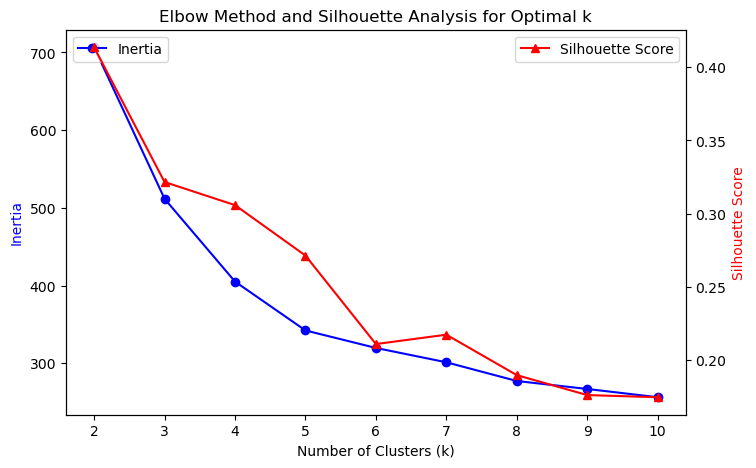

In [14]:
# using Elbow method adn silhouette score to find the optimal number of clusters
inertia = []
silhouette_scores = []
K = range(2, 11)  # Silhouette score requires at least 2 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Curve and Silhouette Scores
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

ax1.plot(K, inertia, 'bo-', label='Inertia')
ax2.plot(K, silhouette_scores, 'r^-', label='Silhouette Score')

ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='b')
ax2.set_ylabel('Silhouette Score', color='r')
plt.title('Elbow Method and Silhouette Analysis for Optimal k')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()



In [16]:
# Based on the elbow plot, let's choose k = 3 as the optimal number of clusters trying 4 also
# Set the number of clusters for k=3 and k=4
kmeans_3 = KMeans(n_clusters=3, random_state=42)
kmeans_4 = KMeans(n_clusters=4, random_state=42)

# Fit the models to the scaled data
kmeans_3.fit(X_scaled)
kmeans_4.fit(X_scaled)

# Get the cluster labels for each k
data['Cluster_k3'] = kmeans_3.labels_
data['Cluster_k4'] = kmeans_4.labels_

# Check the first few rows of the dataframe with both cluster labels
data.head()



,ID,Country of Origin,Altitude,Region,Number of Bags,Bag Weight,Harvest Year,Grading Date,Processing Method,Aroma,...,Acidity,Body,Moisture Percentage,Balance,Overall,Total Cup Points (TO BE RECALCULATED),Category One Defects,Category Two Defects,Cluster_k3,Cluster_k4
0,0,Colombia,1700-1930,"Piendamo,Cauca",1,35 kg,2021 / 2022,"September 21st, 2022",Double Anaerobic Washed,8.58,...,8.58,8.25,11.8,8.42,8.58,89.33,0,3,2,2
1,1,Taiwan,1200,Chiayi,1,80 kg,2021 / 2022,"November 15th, 2022",Washed / Wet,8.50,...,8.00,7.92,10.5,8.25,8.50,87.58,0,0,2,2
2,2,Laos,1300,Laos Borofen Plateau,19,25 kg,2021 / 2022,"November 15th, 2022",Semi Washed,8.33,...,8.17,7.92,10.4,8.17,8.33,87.42,0,2,2,2
3,3,Costa Rica,1900,"Los Santos,Tarrazu",1,22 kg,2022,"September 21st, 2022",Washed / Wet,8.08,...,8.25,8.17,11.8,8.08,8.25,87.17,0,0,2,2
4,4,Colombia,1850-2100,"Popayan,Cauca",2,24 kg,2022,"March 6th, 2023","Honey,Mossto",8.33,...,8.25,7.92,11.6,7.92,8.25,87.08,0,2,2,2


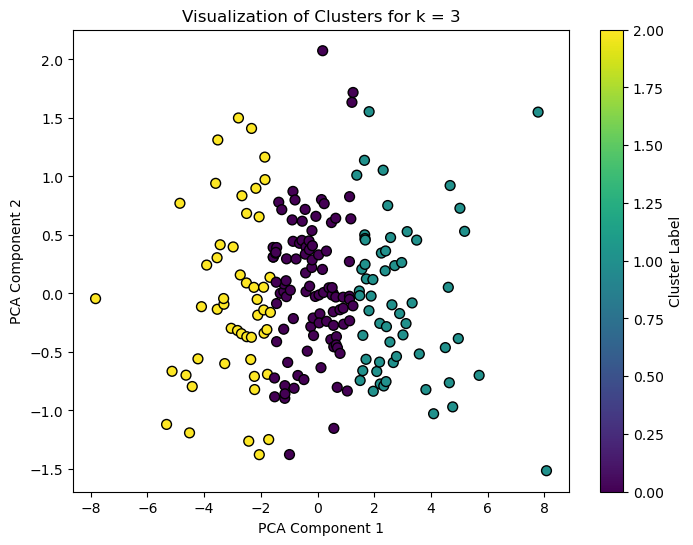

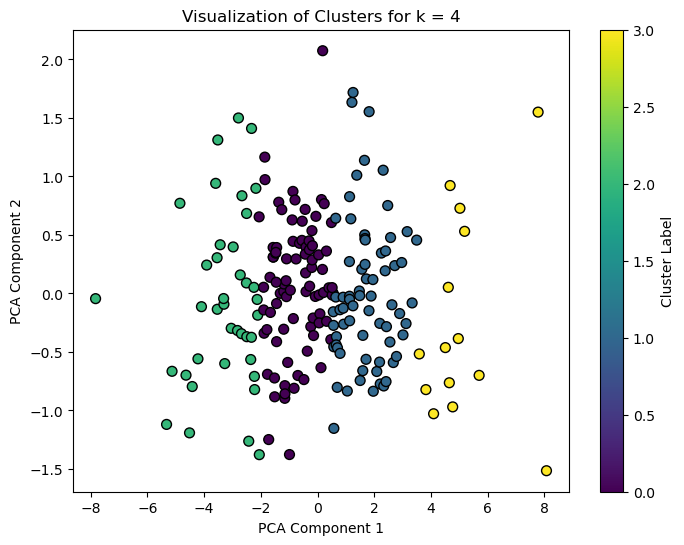

In [18]:
from sklearn.decomposition import PCA

# Function to visualize clusters for a given k
def plot_clusters(k, X_scaled):
    # Fit KMeans with specified number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    
    # Reduce to 2D for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Plot clusters
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
    plt.title(f'Visualization of Clusters for k = {k}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster Label')
    plt.show()

# Visualize clusters for k = 3
plot_clusters(3, X_scaled)

# Visualize clusters for k = 4
plot_clusters(4, X_scaled)



In [41]:
# Create a DataFrame from the scaled data and add the cluster labels
X_df = pd.DataFrame(X, columns=features)  # Assuming 'features' is your list of selected feature names
X_df['Cluster_k3'] = kmeans_3.labels_
X_df['Cluster_k4'] = kmeans_4.labels_


# Display cluster means for k = 3
cluster_means_k3 = X_df.groupby('Cluster_k3').mean()
print("Cluster Means for k = 3:")
print(cluster_means_k3)

# Display cluster means for k = 4
cluster_means_k4 = X_df.groupby('Cluster_k4').mean()
print("\nCluster Means for k = 4:")
print(cluster_means_k4)




Cluster Means for k = 3:
               Aroma    Flavor  Aftertaste   Acidity     Body   Balance  \
Cluster_k3                                                                
0           7.729798  7.772323    7.607576  7.717980  7.66404  7.666162   
1           7.431379  7.424138    7.302069  7.397069  7.39500  7.355345   
2           8.039800  8.062000    7.929600  7.975600  7.88040  7.935200   

             Overall  Cluster_k4  
Cluster_k3                        
0           7.705455    0.252525  
1           7.329310    1.482759  
2           8.023200    1.560000  

Cluster Means for k = 4:
               Aroma    Flavor  Aftertaste   Acidity      Body   Balance  \
Cluster_k4                                                                 
0           7.773529  7.834706    7.656941  7.773765  7.706000  7.717059   
1           7.549855  7.554783    7.427391  7.511014  7.504348  7.478406   
2           8.078462  8.085641    7.975897  7.998462  7.906410  7.968462   
3           7.2507

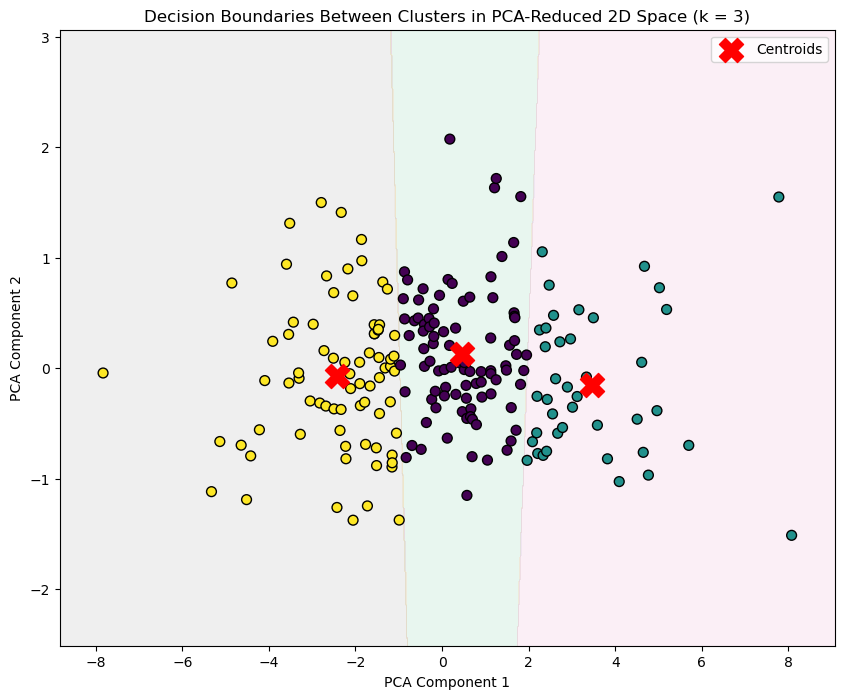

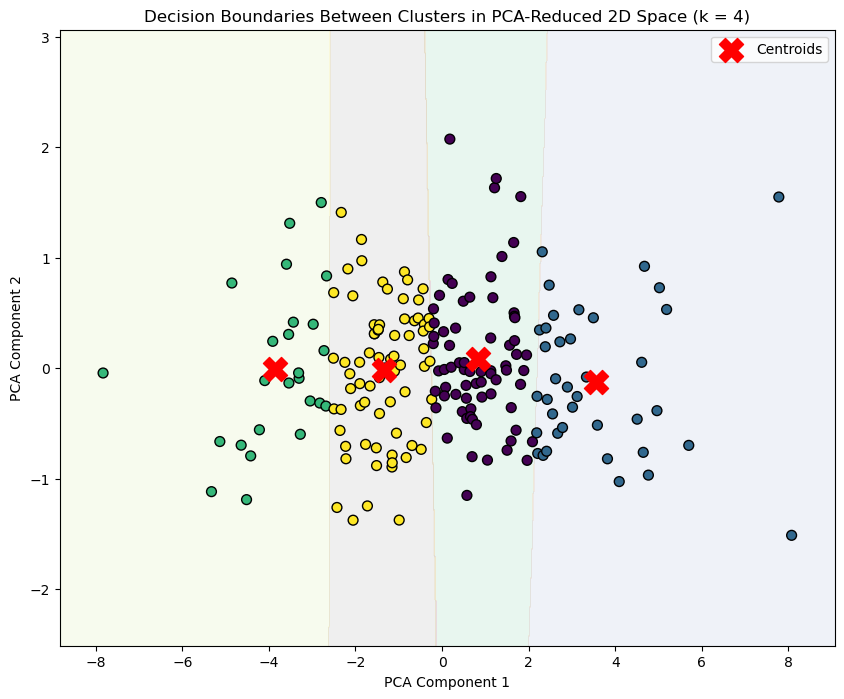

In [43]:

# Reduce the scaled data to 2D for plotting
pca = PCA(n_components=2)
data_pca = pca.fit_transform(X_scaled)

def plot_decision_boundary(k, data_pca):
    # Generate a mesh grid for the decision boundary
    x_min, x_max = data_pca[:, 0].min() - 1, data_pca[:, 0].max() + 1
    y_min, y_max = data_pca[:, 1].min() - 1, data_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Fit KMeans on the PCA-reduced data
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data_pca)
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    cluster_labels = kmeans.labels_
    
    # Plot decision boundaries and data points
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap='Pastel2', alpha=0.3)  # Decision boundaries
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50)  # Data points
    
    # Plot centroids
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='X', label='Centroids')
    
    # Labels and title
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'Decision Boundaries Between Clusters in PCA-Reduced 2D Space (k = {k})')
    plt.legend()
    plt.show()

# Plot for k = 3
plot_decision_boundary(3, data_pca)

# Plot for k = 4
plot_decision_boundary(4, data_pca)


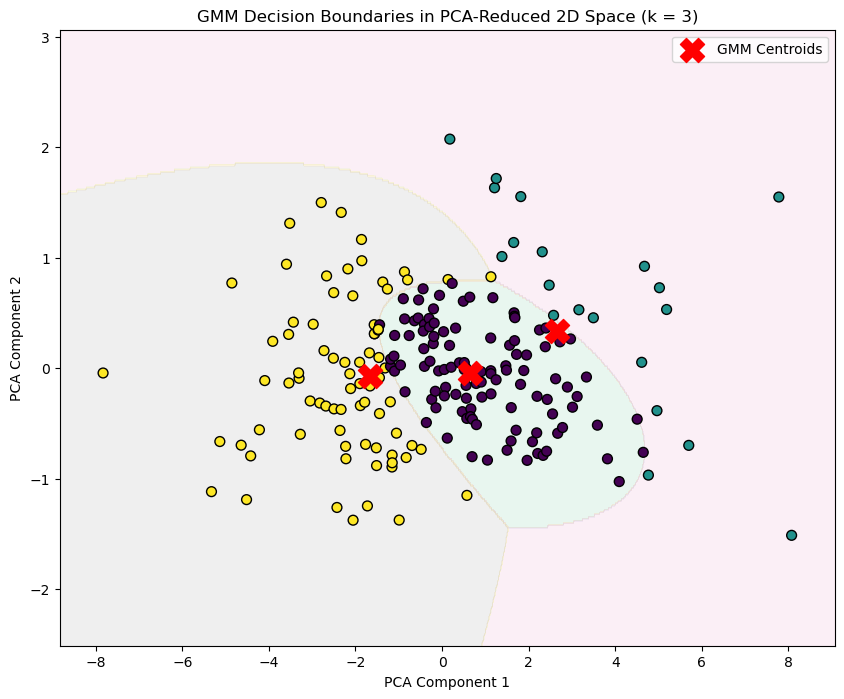

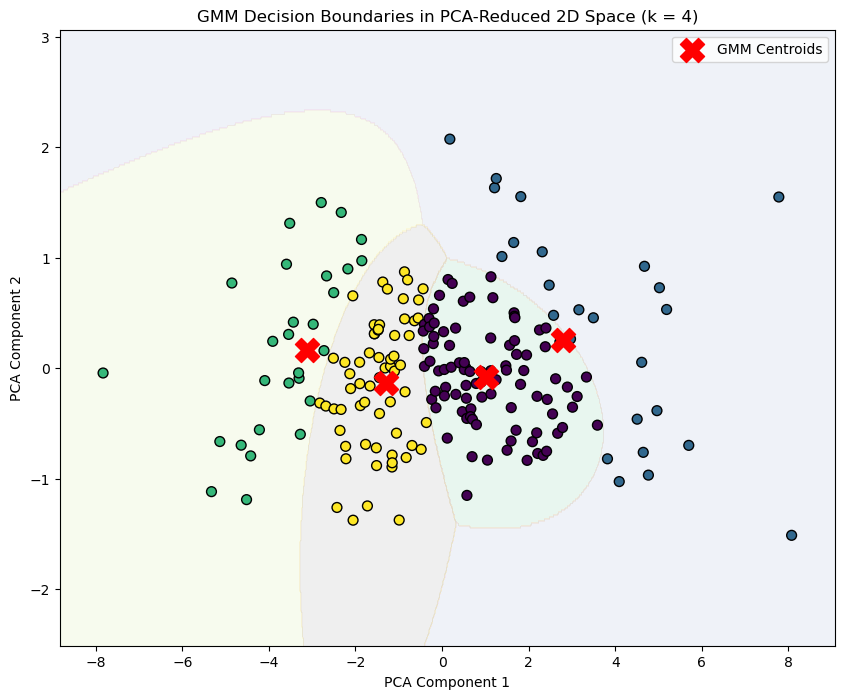

In [47]:


# Function to fit GMM and plot decision boundaries
def plot_gmm_decision_boundary(k, data_pca):
    # Fit the GMM model
    gmm = GaussianMixture(n_components=k, random_state=0)
    gmm.fit(data_pca)
    labels = gmm.predict(data_pca)
    
    # Generate a mesh grid for decision boundaries
    x_min, x_max = data_pca[:, 0].min() - 1, data_pca[:, 0].max() + 1
    y_min, y_max = data_pca[:, 1].min() - 1, data_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Predict on the mesh grid for decision boundary visualization
    Z = gmm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plot decision boundaries and data points
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap='Pastel2', alpha=0.3)  # Decision boundary regions
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)  # Data points
    
    # Plot GMM component means (centroids)
    centroids = gmm.means_
    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='X', label='GMM Centroids')
    
    # Labels and title
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'GMM Decision Boundaries in PCA-Reduced 2D Space (k = {k})')
    plt.legend()
    plt.show()

# Plot for GMM with k = 3
plot_gmm_decision_boundary(3, data_pca)

# Plot for GMM with k = 4
plot_gmm_decision_boundary(4, data_pca)
